For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

## **Flows based Models using RealNVP**



### **Understanding Normalizing Flows (NF)**

Normalizing Flows are generative models used to:

* Model complex data distributions by applying an invertible transformation to a simple base distribution (e.g., Gaussian).  
* Evaluate exact likelihoods through the change of variables formula.  
* Generate new samples by applying the inverse transformation to samples drawn from the simple base distribution.

A Normalizing Flow consists of a series of invertible and differentiable mappings:  
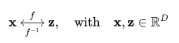 

We define the **log-likelihood** of the data x\\mathbf{x}x using a change of variables:   
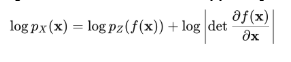

### **RealNVP – the Theory**

RealNVP simplifies Normalizing Flows by using a coupling layer architecture. This structure ensures invertibility and efficient computation of the Jacobian determinant.

A RealNVP coupling layer partitions the input data x\\mathbf{x}x into two parts: xa\\mathbf{x}\_axa​ and xb\\mathbf{x}\_bxb​:

* xa​ remains unchanged.  
* xb is transformed based on parameters computed from xa​.

#### **Forward pass (data → latent space):**

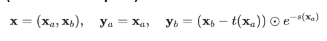

#### **Inverse pass (latent space → data):**

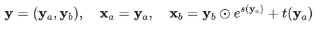

* Functions s(⋅) and t(⋅) are neural networks called **scale** and **translation** networks.  
* ⊙ denotes element-wise multiplication.

#### **Jacobian Determinant:**

The Jacobian of a RealNVP coupling layer is a lower-triangular block matrix whose determinant simplifies dramatically:

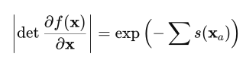

This efficient computation is a key advantage of RealNVP.

## **Dataset Preparation (Moon Dataset)**

* Generate synthetic data   
* Normalize dataset


In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Hyperparameters
INPUT_DIM = 2
COUPLING_DIM = 256
COUPLING_LAYERS = 4
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 300
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
class MoonsDataset(Dataset):
    def __init__(self, n_samples=30000, noise=0.05):
        data, _ = make_moons(n_samples=n_samples, noise=noise)
        self.data = ((data - data.mean(0)) / data.std(0)).astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]




## **RealNVP Architecture**

RealNVP consists of multiple coupling layers with alternating masks:

* Alternate masks: e.g. \[0,1\], \[1,0\], to alternate transformed dimensions.  
* Use multiple coupling layers to increase modeling power.

### **Forward pass (data → latent):**

* Iteratively pass input through coupling layers.  
* Calculate cumulative log-determinant of Jacobians.

### **Inverse pass (latent → data, for sampling):**

* Reverse direction through coupling layers.  
* No log-determinant calculation required during sampling.

## **Training Procedure**

**Goal:** Maximize the likelihood (or equivalently minimize negative log-likelihood)

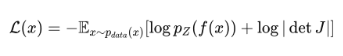

* Optimize with Adam optimizer.  
* Use PyTorch for automatic differentiation.


In [6]:

# Corrected Coupling Layer
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2), nn.Tanh())

        self.translate_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2))

    def forward(self, x, mask, reverse=False):
        x_a = x * mask
        x_b = x * (1 - mask)

        # Pass only x_a's non-zero dimensions to the networks
        x_a_cond = x_a[:, mask.bool()]
        
        s = self.scale_net(x_a_cond)
        t = self.translate_net(x_a_cond)

        if not reverse:
            y_b = (x_b[:, (1 - mask).bool()] * torch.exp(s)) + t
            log_det_jac = s.sum(dim=1)
        else:
            y_b = (x_b[:, (1 - mask).bool()] - t) * torch.exp(-s)
            log_det_jac = -s.sum(dim=1)

        # Reconstruct the output
        y = torch.zeros_like(x)
        y[:, mask.bool()] = x_a_cond
        y[:, (1 - mask).bool()] = y_b

        return y, log_det_jac


# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super().__init__()
        self.prior = torch.distributions.MultivariateNormal(torch.zeros(input_dim).to(DEVICE), torch.eye(input_dim).to(DEVICE))
        self.layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)])
        self.masks = [torch.tensor([i % 2, (i+1) % 2]).float().to(DEVICE) for i in range(num_flows)]

    def forward(self, x):
        log_det_J = 0
        for layer, mask in zip(self.layers, self.masks):
            x, log_det = layer(x, mask)
            log_det_J += log_det
        return x, log_det_J

    def loss(self, x):
        z, log_det_J = self(x)
        log_prob = self.prior.log_prob(z)
        return -(log_det_J + log_prob).mean()

    def sample(self, num_samples):
        z = self.prior.sample((num_samples,))
        for layer, mask in reversed(list(zip(self.layers, self.masks))):
            z, _ = layer(z, mask, reverse=True)
        return z



## **Training Loop:**

* Iterate over epochs.  
* For each batch:  
  * Compute loss.  
  * Backpropagation and parameter updates.  
* Use `tqdm` for progress bar visualization and live feedback on loss.


In [7]:

def train(model, loader, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        tqdm_loader = tqdm(loader, desc=f"Training RealNVP - Epoch {epoch+1}/{epochs}")

        for batch in tqdm_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            tqdm_loader.set_postfix(loss=loss.item())

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {total_loss:.6f} ")


## **Sampling Procedure:**

To generate new samples:

1. Draw samples z ∼ N(0,I).  
2. Transform samples via inverse coupling layers to data space.

## **Visualization:**

* Visualize sampled data and original dataset to qualitatively evaluate the model.  
* Use scatter plots for clear representation.


Training RealNVP - Epoch 1/300: 100%|██████████| 118/118 [00:04<00:00, 26.37it/s, loss=2.13]


Epoch [1/300], Train Loss: 276.136647 


Training RealNVP - Epoch 2/300: 100%|██████████| 118/118 [00:02<00:00, 42.85it/s, loss=2.17]


Epoch [2/300], Train Loss: 243.931824 


Training RealNVP - Epoch 3/300: 100%|██████████| 118/118 [00:02<00:00, 39.58it/s, loss=1.94]


Epoch [3/300], Train Loss: 232.077937 


Training RealNVP - Epoch 4/300: 100%|██████████| 118/118 [00:02<00:00, 39.64it/s, loss=1.73]


Epoch [4/300], Train Loss: 222.754995 


Training RealNVP - Epoch 5/300: 100%|██████████| 118/118 [00:03<00:00, 39.05it/s, loss=1.75]


Epoch [5/300], Train Loss: 213.089168 


Training RealNVP - Epoch 6/300: 100%|██████████| 118/118 [00:02<00:00, 39.65it/s, loss=1.9] 


Epoch [6/300], Train Loss: 207.488936 


Training RealNVP - Epoch 7/300: 100%|██████████| 118/118 [00:02<00:00, 39.96it/s, loss=1.83]


Epoch [7/300], Train Loss: 204.485988 


Training RealNVP - Epoch 8/300: 100%|██████████| 118/118 [00:02<00:00, 39.52it/s, loss=1.69]


Epoch [8/300], Train Loss: 203.196875 


Training RealNVP - Epoch 9/300: 100%|██████████| 118/118 [00:02<00:00, 39.87it/s, loss=1.86]


Epoch [9/300], Train Loss: 198.516898 


Training RealNVP - Epoch 10/300: 100%|██████████| 118/118 [00:03<00:00, 38.42it/s, loss=1.83]


Epoch [10/300], Train Loss: 198.444287 


Training RealNVP - Epoch 11/300: 100%|██████████| 118/118 [00:02<00:00, 39.88it/s, loss=1.69]


Epoch [11/300], Train Loss: 198.526145 


Training RealNVP - Epoch 12/300: 100%|██████████| 118/118 [00:02<00:00, 40.05it/s, loss=1.57]


Epoch [12/300], Train Loss: 196.552604 


Training RealNVP - Epoch 13/300: 100%|██████████| 118/118 [00:02<00:00, 39.92it/s, loss=1.54]


Epoch [13/300], Train Loss: 196.810015 


Training RealNVP - Epoch 14/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.63]


Epoch [14/300], Train Loss: 195.949409 


Training RealNVP - Epoch 15/300: 100%|██████████| 118/118 [00:02<00:00, 39.67it/s, loss=1.65]


Epoch [15/300], Train Loss: 196.459161 


Training RealNVP - Epoch 16/300: 100%|██████████| 118/118 [00:02<00:00, 39.80it/s, loss=1.58]


Epoch [16/300], Train Loss: 194.824764 


Training RealNVP - Epoch 17/300: 100%|██████████| 118/118 [00:03<00:00, 38.87it/s, loss=1.71]


Epoch [17/300], Train Loss: 194.779542 


Training RealNVP - Epoch 18/300: 100%|██████████| 118/118 [00:02<00:00, 39.47it/s, loss=1.89]


Epoch [18/300], Train Loss: 194.305471 


Training RealNVP - Epoch 19/300: 100%|██████████| 118/118 [00:03<00:00, 39.31it/s, loss=1.74]


Epoch [19/300], Train Loss: 194.576683 


Training RealNVP - Epoch 20/300: 100%|██████████| 118/118 [00:02<00:00, 40.13it/s, loss=1.57]


Epoch [20/300], Train Loss: 197.661721 


Training RealNVP - Epoch 21/300: 100%|██████████| 118/118 [00:03<00:00, 39.26it/s, loss=1.53]


Epoch [21/300], Train Loss: 191.887421 


Training RealNVP - Epoch 22/300: 100%|██████████| 118/118 [00:02<00:00, 39.62it/s, loss=1.54]


Epoch [22/300], Train Loss: 192.620297 


Training RealNVP - Epoch 23/300: 100%|██████████| 118/118 [00:02<00:00, 39.57it/s, loss=1.69]


Epoch [23/300], Train Loss: 192.570450 


Training RealNVP - Epoch 24/300: 100%|██████████| 118/118 [00:02<00:00, 39.64it/s, loss=1.54]


Epoch [24/300], Train Loss: 192.236634 


Training RealNVP - Epoch 25/300: 100%|██████████| 118/118 [00:03<00:00, 39.20it/s, loss=1.6] 


Epoch [25/300], Train Loss: 190.923324 


Training RealNVP - Epoch 26/300: 100%|██████████| 118/118 [00:02<00:00, 40.08it/s, loss=1.58]


Epoch [26/300], Train Loss: 192.229582 


Training RealNVP - Epoch 27/300: 100%|██████████| 118/118 [00:02<00:00, 39.42it/s, loss=1.58]


Epoch [27/300], Train Loss: 192.606659 


Training RealNVP - Epoch 28/300: 100%|██████████| 118/118 [00:02<00:00, 39.40it/s, loss=1.55]


Epoch [28/300], Train Loss: 193.283178 


Training RealNVP - Epoch 29/300: 100%|██████████| 118/118 [00:02<00:00, 39.56it/s, loss=1.75]


Epoch [29/300], Train Loss: 193.577187 


Training RealNVP - Epoch 30/300: 100%|██████████| 118/118 [00:02<00:00, 39.64it/s, loss=1.47]


Epoch [30/300], Train Loss: 190.964273 


Training RealNVP - Epoch 31/300: 100%|██████████| 118/118 [00:02<00:00, 39.59it/s, loss=1.43]


Epoch [31/300], Train Loss: 190.670092 


Training RealNVP - Epoch 32/300: 100%|██████████| 118/118 [00:03<00:00, 39.31it/s, loss=1.53]


Epoch [32/300], Train Loss: 190.757318 


Training RealNVP - Epoch 33/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.66]


Epoch [33/300], Train Loss: 190.712893 


Training RealNVP - Epoch 34/300: 100%|██████████| 118/118 [00:03<00:00, 39.12it/s, loss=1.62]


Epoch [34/300], Train Loss: 190.711120 


Training RealNVP - Epoch 35/300: 100%|██████████| 118/118 [00:02<00:00, 39.62it/s, loss=1.61]


Epoch [35/300], Train Loss: 187.750504 


Training RealNVP - Epoch 36/300: 100%|██████████| 118/118 [00:03<00:00, 39.06it/s, loss=1.42]


Epoch [36/300], Train Loss: 188.818092 


Training RealNVP - Epoch 37/300: 100%|██████████| 118/118 [00:03<00:00, 39.00it/s, loss=1.63]


Epoch [37/300], Train Loss: 189.039948 


Training RealNVP - Epoch 38/300: 100%|██████████| 118/118 [00:02<00:00, 39.70it/s, loss=1.56]


Epoch [38/300], Train Loss: 190.959605 


Training RealNVP - Epoch 39/300: 100%|██████████| 118/118 [00:02<00:00, 39.74it/s, loss=1.92]


Epoch [39/300], Train Loss: 190.816298 


Training RealNVP - Epoch 40/300: 100%|██████████| 118/118 [00:03<00:00, 39.17it/s, loss=1.67]


Epoch [40/300], Train Loss: 189.888082 


Training RealNVP - Epoch 41/300: 100%|██████████| 118/118 [00:03<00:00, 39.11it/s, loss=1.78]


Epoch [41/300], Train Loss: 189.213258 


Training RealNVP - Epoch 42/300: 100%|██████████| 118/118 [00:03<00:00, 38.98it/s, loss=1.73]


Epoch [42/300], Train Loss: 191.607182 


Training RealNVP - Epoch 43/300: 100%|██████████| 118/118 [00:02<00:00, 39.67it/s, loss=1.65]


Epoch [43/300], Train Loss: 189.129748 


Training RealNVP - Epoch 44/300: 100%|██████████| 118/118 [00:02<00:00, 39.93it/s, loss=1.41]


Epoch [44/300], Train Loss: 189.247025 


Training RealNVP - Epoch 45/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.54]


Epoch [45/300], Train Loss: 190.168125 


Training RealNVP - Epoch 46/300: 100%|██████████| 118/118 [00:02<00:00, 39.35it/s, loss=1.45]


Epoch [46/300], Train Loss: 189.223216 


Training RealNVP - Epoch 47/300: 100%|██████████| 118/118 [00:03<00:00, 39.33it/s, loss=1.64]


Epoch [47/300], Train Loss: 188.355643 


Training RealNVP - Epoch 48/300: 100%|██████████| 118/118 [00:02<00:00, 39.55it/s, loss=1.62]


Epoch [48/300], Train Loss: 191.450080 


Training RealNVP - Epoch 49/300: 100%|██████████| 118/118 [00:03<00:00, 39.00it/s, loss=1.68]


Epoch [49/300], Train Loss: 192.493877 


Training RealNVP - Epoch 50/300: 100%|██████████| 118/118 [00:02<00:00, 39.67it/s, loss=1.63]


Epoch [50/300], Train Loss: 186.807930 


Training RealNVP - Epoch 51/300: 100%|██████████| 118/118 [00:02<00:00, 39.37it/s, loss=1.41]


Epoch [51/300], Train Loss: 189.479207 


Training RealNVP - Epoch 52/300: 100%|██████████| 118/118 [00:02<00:00, 39.48it/s, loss=1.45]


Epoch [52/300], Train Loss: 194.495809 


Training RealNVP - Epoch 53/300: 100%|██████████| 118/118 [00:02<00:00, 39.43it/s, loss=1.49]


Epoch [53/300], Train Loss: 187.792447 


Training RealNVP - Epoch 54/300: 100%|██████████| 118/118 [00:02<00:00, 39.79it/s, loss=1.59]


Epoch [54/300], Train Loss: 187.756221 


Training RealNVP - Epoch 55/300: 100%|██████████| 118/118 [00:02<00:00, 39.35it/s, loss=1.56]


Epoch [55/300], Train Loss: 186.723372 


Training RealNVP - Epoch 56/300: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s, loss=1.69]


Epoch [56/300], Train Loss: 186.571876 


Training RealNVP - Epoch 57/300: 100%|██████████| 118/118 [00:03<00:00, 39.15it/s, loss=1.37]


Epoch [57/300], Train Loss: 185.534169 


Training RealNVP - Epoch 58/300: 100%|██████████| 118/118 [00:03<00:00, 39.20it/s, loss=1.48]


Epoch [58/300], Train Loss: 185.973159 


Training RealNVP - Epoch 59/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.58]


Epoch [59/300], Train Loss: 186.349695 


Training RealNVP - Epoch 60/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.85]


Epoch [60/300], Train Loss: 186.780813 


Training RealNVP - Epoch 61/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.77]


Epoch [61/300], Train Loss: 187.083046 


Training RealNVP - Epoch 62/300: 100%|██████████| 118/118 [00:02<00:00, 39.37it/s, loss=1.64]


Epoch [62/300], Train Loss: 187.015048 


Training RealNVP - Epoch 63/300: 100%|██████████| 118/118 [00:02<00:00, 39.84it/s, loss=1.52]


Epoch [63/300], Train Loss: 191.471549 


Training RealNVP - Epoch 64/300: 100%|██████████| 118/118 [00:02<00:00, 39.64it/s, loss=1.73]


Epoch [64/300], Train Loss: 184.185989 


Training RealNVP - Epoch 65/300: 100%|██████████| 118/118 [00:02<00:00, 39.54it/s, loss=1.54]


Epoch [65/300], Train Loss: 189.072545 


Training RealNVP - Epoch 66/300: 100%|██████████| 118/118 [00:02<00:00, 39.45it/s, loss=1.62]


Epoch [66/300], Train Loss: 185.810352 


Training RealNVP - Epoch 67/300: 100%|██████████| 118/118 [00:02<00:00, 39.61it/s, loss=1.86]


Epoch [67/300], Train Loss: 182.949861 


Training RealNVP - Epoch 68/300: 100%|██████████| 118/118 [00:02<00:00, 39.51it/s, loss=1.81]


Epoch [68/300], Train Loss: 186.773698 


Training RealNVP - Epoch 69/300: 100%|██████████| 118/118 [00:03<00:00, 38.98it/s, loss=1.61]


Epoch [69/300], Train Loss: 192.573119 


Training RealNVP - Epoch 70/300: 100%|██████████| 118/118 [00:02<00:00, 39.46it/s, loss=1.7] 


Epoch [70/300], Train Loss: 190.124468 


Training RealNVP - Epoch 71/300: 100%|██████████| 118/118 [00:02<00:00, 39.88it/s, loss=1.42]


Epoch [71/300], Train Loss: 191.854180 


Training RealNVP - Epoch 72/300: 100%|██████████| 118/118 [00:03<00:00, 39.31it/s, loss=1.65]


Epoch [72/300], Train Loss: 187.662040 


Training RealNVP - Epoch 73/300: 100%|██████████| 118/118 [00:03<00:00, 39.09it/s, loss=1.49]


Epoch [73/300], Train Loss: 187.790976 


Training RealNVP - Epoch 74/300: 100%|██████████| 118/118 [00:02<00:00, 39.84it/s, loss=1.79]


Epoch [74/300], Train Loss: 187.739597 


Training RealNVP - Epoch 75/300: 100%|██████████| 118/118 [00:03<00:00, 39.24it/s, loss=1.53]


Epoch [75/300], Train Loss: 186.973554 


Training RealNVP - Epoch 76/300: 100%|██████████| 118/118 [00:02<00:00, 39.98it/s, loss=1.47]


Epoch [76/300], Train Loss: 185.287586 


Training RealNVP - Epoch 77/300: 100%|██████████| 118/118 [00:03<00:00, 39.03it/s, loss=1.53]


Epoch [77/300], Train Loss: 184.512013 


Training RealNVP - Epoch 78/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.44]


Epoch [78/300], Train Loss: 184.262820 


Training RealNVP - Epoch 79/300: 100%|██████████| 118/118 [00:03<00:00, 39.25it/s, loss=1.68]


Epoch [79/300], Train Loss: 186.128233 


Training RealNVP - Epoch 80/300: 100%|██████████| 118/118 [00:02<00:00, 39.57it/s, loss=1.47]


Epoch [80/300], Train Loss: 183.140314 


Training RealNVP - Epoch 81/300: 100%|██████████| 118/118 [00:03<00:00, 39.22it/s, loss=1.51]


Epoch [81/300], Train Loss: 182.840059 


Training RealNVP - Epoch 82/300: 100%|██████████| 118/118 [00:02<00:00, 39.66it/s, loss=1.58]


Epoch [82/300], Train Loss: 185.655933 


Training RealNVP - Epoch 83/300: 100%|██████████| 118/118 [00:03<00:00, 35.83it/s, loss=1.46]


Epoch [83/300], Train Loss: 194.576386 


Training RealNVP - Epoch 84/300: 100%|██████████| 118/118 [00:03<00:00, 39.19it/s, loss=1.49]


Epoch [84/300], Train Loss: 185.764081 


Training RealNVP - Epoch 85/300: 100%|██████████| 118/118 [00:03<00:00, 38.91it/s, loss=1.48]


Epoch [85/300], Train Loss: 181.360700 


Training RealNVP - Epoch 86/300: 100%|██████████| 118/118 [00:03<00:00, 39.07it/s, loss=1.41]


Epoch [86/300], Train Loss: 184.587272 


Training RealNVP - Epoch 87/300: 100%|██████████| 118/118 [00:03<00:00, 39.29it/s, loss=1.39]


Epoch [87/300], Train Loss: 186.355664 


Training RealNVP - Epoch 88/300: 100%|██████████| 118/118 [00:02<00:00, 39.39it/s, loss=1.56]


Epoch [88/300], Train Loss: 182.696166 


Training RealNVP - Epoch 89/300: 100%|██████████| 118/118 [00:03<00:00, 39.22it/s, loss=1.33]


Epoch [89/300], Train Loss: 184.668086 


Training RealNVP - Epoch 90/300: 100%|██████████| 118/118 [00:03<00:00, 39.01it/s, loss=1.32]


Epoch [90/300], Train Loss: 181.796280 


Training RealNVP - Epoch 91/300: 100%|██████████| 118/118 [00:02<00:00, 39.59it/s, loss=1.55]


Epoch [91/300], Train Loss: 187.410913 


Training RealNVP - Epoch 92/300: 100%|██████████| 118/118 [00:03<00:00, 39.23it/s, loss=1.57]


Epoch [92/300], Train Loss: 183.829338 


Training RealNVP - Epoch 93/300: 100%|██████████| 118/118 [00:02<00:00, 39.70it/s, loss=1.38]


Epoch [93/300], Train Loss: 185.431625 


Training RealNVP - Epoch 94/300: 100%|██████████| 118/118 [00:02<00:00, 39.76it/s, loss=1.77]


Epoch [94/300], Train Loss: 191.730245 


Training RealNVP - Epoch 95/300: 100%|██████████| 118/118 [00:02<00:00, 39.44it/s, loss=1.52]


Epoch [95/300], Train Loss: 189.276066 


Training RealNVP - Epoch 96/300: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s, loss=1.5] 


Epoch [96/300], Train Loss: 184.411360 


Training RealNVP - Epoch 97/300: 100%|██████████| 118/118 [00:03<00:00, 38.75it/s, loss=1.48]


Epoch [97/300], Train Loss: 180.247235 


Training RealNVP - Epoch 98/300: 100%|██████████| 118/118 [00:03<00:00, 37.91it/s, loss=1.45]


Epoch [98/300], Train Loss: 179.672225 


Training RealNVP - Epoch 99/300: 100%|██████████| 118/118 [00:02<00:00, 39.55it/s, loss=1.53]


Epoch [99/300], Train Loss: 180.161959 


Training RealNVP - Epoch 100/300: 100%|██████████| 118/118 [00:02<00:00, 40.23it/s, loss=1.51]


Epoch [100/300], Train Loss: 180.079157 


Training RealNVP - Epoch 101/300: 100%|██████████| 118/118 [00:02<00:00, 39.60it/s, loss=1.75]


Epoch [101/300], Train Loss: 182.132522 


Training RealNVP - Epoch 102/300: 100%|██████████| 118/118 [00:02<00:00, 39.73it/s, loss=1.49]


Epoch [102/300], Train Loss: 181.467891 


Training RealNVP - Epoch 103/300: 100%|██████████| 118/118 [00:03<00:00, 39.05it/s, loss=1.4] 


Epoch [103/300], Train Loss: 181.196449 


Training RealNVP - Epoch 104/300: 100%|██████████| 118/118 [00:03<00:00, 39.09it/s, loss=1.52]


Epoch [104/300], Train Loss: 182.496242 


Training RealNVP - Epoch 105/300: 100%|██████████| 118/118 [00:02<00:00, 39.60it/s, loss=1.55]


Epoch [105/300], Train Loss: 178.574827 


Training RealNVP - Epoch 106/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.63]


Epoch [106/300], Train Loss: 181.743736 


Training RealNVP - Epoch 107/300: 100%|██████████| 118/118 [00:02<00:00, 39.55it/s, loss=1.35]


Epoch [107/300], Train Loss: 193.150670 


Training RealNVP - Epoch 108/300: 100%|██████████| 118/118 [00:02<00:00, 39.70it/s, loss=1.51]


Epoch [108/300], Train Loss: 178.208648 


Training RealNVP - Epoch 109/300: 100%|██████████| 118/118 [00:03<00:00, 39.07it/s, loss=1.38]


Epoch [109/300], Train Loss: 177.293879 


Training RealNVP - Epoch 110/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.58]


Epoch [110/300], Train Loss: 174.710682 


Training RealNVP - Epoch 111/300: 100%|██████████| 118/118 [00:02<00:00, 39.83it/s, loss=1.43]


Epoch [111/300], Train Loss: 176.643510 


Training RealNVP - Epoch 112/300: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s, loss=1.34]


Epoch [112/300], Train Loss: 174.417766 


Training RealNVP - Epoch 113/300: 100%|██████████| 118/118 [00:03<00:00, 39.10it/s, loss=1.48]


Epoch [113/300], Train Loss: 174.412760 


Training RealNVP - Epoch 114/300: 100%|██████████| 118/118 [00:02<00:00, 39.75it/s, loss=1.42]


Epoch [114/300], Train Loss: 175.287037 


Training RealNVP - Epoch 115/300: 100%|██████████| 118/118 [00:02<00:00, 39.44it/s, loss=1.44]


Epoch [115/300], Train Loss: 174.776519 


Training RealNVP - Epoch 116/300: 100%|██████████| 118/118 [00:03<00:00, 39.07it/s, loss=1.4] 


Epoch [116/300], Train Loss: 174.324358 


Training RealNVP - Epoch 117/300: 100%|██████████| 118/118 [00:02<00:00, 39.40it/s, loss=1.48]


Epoch [117/300], Train Loss: 173.600982 


Training RealNVP - Epoch 118/300: 100%|██████████| 118/118 [00:02<00:00, 39.51it/s, loss=1.4] 


Epoch [118/300], Train Loss: 173.794608 


Training RealNVP - Epoch 119/300: 100%|██████████| 118/118 [00:03<00:00, 39.07it/s, loss=1.23]


Epoch [119/300], Train Loss: 172.375936 


Training RealNVP - Epoch 120/300: 100%|██████████| 118/118 [00:02<00:00, 39.66it/s, loss=1.52]


Epoch [120/300], Train Loss: 171.302575 


Training RealNVP - Epoch 121/300: 100%|██████████| 118/118 [00:02<00:00, 39.70it/s, loss=1.36]


Epoch [121/300], Train Loss: 171.929528 


Training RealNVP - Epoch 122/300: 100%|██████████| 118/118 [00:02<00:00, 39.36it/s, loss=1.51]


Epoch [122/300], Train Loss: 170.643581 


Training RealNVP - Epoch 123/300: 100%|██████████| 118/118 [00:02<00:00, 39.87it/s, loss=1.37]


Epoch [123/300], Train Loss: 171.491698 


Training RealNVP - Epoch 124/300: 100%|██████████| 118/118 [00:03<00:00, 39.16it/s, loss=1.35]


Epoch [124/300], Train Loss: 172.859006 


Training RealNVP - Epoch 125/300: 100%|██████████| 118/118 [00:02<00:00, 39.92it/s, loss=1.44]


Epoch [125/300], Train Loss: 171.932650 


Training RealNVP - Epoch 126/300: 100%|██████████| 118/118 [00:02<00:00, 39.96it/s, loss=1.43]


Epoch [126/300], Train Loss: 168.534396 


Training RealNVP - Epoch 127/300: 100%|██████████| 118/118 [00:03<00:00, 39.00it/s, loss=1.51]


Epoch [127/300], Train Loss: 171.855602 


Training RealNVP - Epoch 128/300: 100%|██████████| 118/118 [00:03<00:00, 39.28it/s, loss=1.31]


Epoch [128/300], Train Loss: 169.317445 


Training RealNVP - Epoch 129/300: 100%|██████████| 118/118 [00:03<00:00, 39.33it/s, loss=1.6] 


Epoch [129/300], Train Loss: 172.641220 


Training RealNVP - Epoch 130/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.34]


Epoch [130/300], Train Loss: 169.256764 


Training RealNVP - Epoch 131/300: 100%|██████████| 118/118 [00:02<00:00, 39.67it/s, loss=1.53]


Epoch [131/300], Train Loss: 170.766605 


Training RealNVP - Epoch 132/300: 100%|██████████| 118/118 [00:02<00:00, 39.51it/s, loss=1.59]


Epoch [132/300], Train Loss: 168.454583 


Training RealNVP - Epoch 133/300: 100%|██████████| 118/118 [00:02<00:00, 39.66it/s, loss=1.47]


Epoch [133/300], Train Loss: 166.845224 


Training RealNVP - Epoch 134/300: 100%|██████████| 118/118 [00:02<00:00, 39.77it/s, loss=1.39]


Epoch [134/300], Train Loss: 170.767165 


Training RealNVP - Epoch 135/300: 100%|██████████| 118/118 [00:03<00:00, 39.05it/s, loss=1.45]


Epoch [135/300], Train Loss: 167.070630 


Training RealNVP - Epoch 136/300: 100%|██████████| 118/118 [00:03<00:00, 36.22it/s, loss=1.3] 


Epoch [136/300], Train Loss: 170.587328 


Training RealNVP - Epoch 137/300: 100%|██████████| 118/118 [00:03<00:00, 36.11it/s, loss=1.33]


Epoch [137/300], Train Loss: 168.750475 


Training RealNVP - Epoch 138/300: 100%|██████████| 118/118 [00:03<00:00, 38.80it/s, loss=1.65]


Epoch [138/300], Train Loss: 167.966582 


Training RealNVP - Epoch 139/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.35]


Epoch [139/300], Train Loss: 179.384683 


Training RealNVP - Epoch 140/300: 100%|██████████| 118/118 [00:02<00:00, 39.66it/s, loss=1.37]


Epoch [140/300], Train Loss: 166.301970 


Training RealNVP - Epoch 141/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.47]


Epoch [141/300], Train Loss: 165.587733 


Training RealNVP - Epoch 142/300: 100%|██████████| 118/118 [00:03<00:00, 39.01it/s, loss=1.39]


Epoch [142/300], Train Loss: 165.828948 


Training RealNVP - Epoch 143/300: 100%|██████████| 118/118 [00:02<00:00, 40.04it/s, loss=1.4] 


Epoch [143/300], Train Loss: 166.913111 


Training RealNVP - Epoch 144/300: 100%|██████████| 118/118 [00:03<00:00, 39.24it/s, loss=1.54]


Epoch [144/300], Train Loss: 167.251569 


Training RealNVP - Epoch 145/300: 100%|██████████| 118/118 [00:03<00:00, 39.18it/s, loss=1.4] 


Epoch [145/300], Train Loss: 164.053690 


Training RealNVP - Epoch 146/300: 100%|██████████| 118/118 [00:02<00:00, 39.72it/s, loss=1.72]


Epoch [146/300], Train Loss: 165.174742 


Training RealNVP - Epoch 147/300: 100%|██████████| 118/118 [00:03<00:00, 39.15it/s, loss=1.64]


Epoch [147/300], Train Loss: 164.850169 


Training RealNVP - Epoch 148/300: 100%|██████████| 118/118 [00:03<00:00, 39.25it/s, loss=1.52]


Epoch [148/300], Train Loss: 168.268291 


Training RealNVP - Epoch 149/300: 100%|██████████| 118/118 [00:02<00:00, 39.65it/s, loss=1.46]


Epoch [149/300], Train Loss: 163.540691 


Training RealNVP - Epoch 150/300: 100%|██████████| 118/118 [00:02<00:00, 39.52it/s, loss=1.7] 


Epoch [150/300], Train Loss: 163.523565 


Training RealNVP - Epoch 151/300: 100%|██████████| 118/118 [00:03<00:00, 39.17it/s, loss=1.34]


Epoch [151/300], Train Loss: 169.117746 


Training RealNVP - Epoch 152/300: 100%|██████████| 118/118 [00:02<00:00, 39.92it/s, loss=1.43]


Epoch [152/300], Train Loss: 164.797190 


Training RealNVP - Epoch 153/300: 100%|██████████| 118/118 [00:02<00:00, 39.76it/s, loss=1.46]


Epoch [153/300], Train Loss: 164.639568 


Training RealNVP - Epoch 154/300: 100%|██████████| 118/118 [00:03<00:00, 39.22it/s, loss=1.55]


Epoch [154/300], Train Loss: 165.332538 


Training RealNVP - Epoch 155/300: 100%|██████████| 118/118 [00:02<00:00, 39.88it/s, loss=1.45]


Epoch [155/300], Train Loss: 162.625726 


Training RealNVP - Epoch 156/300: 100%|██████████| 118/118 [00:03<00:00, 39.06it/s, loss=1.08]


Epoch [156/300], Train Loss: 163.895303 


Training RealNVP - Epoch 157/300: 100%|██████████| 118/118 [00:03<00:00, 39.13it/s, loss=1.34]


Epoch [157/300], Train Loss: 163.078111 


Training RealNVP - Epoch 158/300: 100%|██████████| 118/118 [00:02<00:00, 39.81it/s, loss=1.25]


Epoch [158/300], Train Loss: 163.692269 


Training RealNVP - Epoch 159/300: 100%|██████████| 118/118 [00:02<00:00, 39.37it/s, loss=1.4] 


Epoch [159/300], Train Loss: 166.187818 


Training RealNVP - Epoch 160/300: 100%|██████████| 118/118 [00:02<00:00, 39.57it/s, loss=1.54]


Epoch [160/300], Train Loss: 164.064036 


Training RealNVP - Epoch 161/300: 100%|██████████| 118/118 [00:02<00:00, 39.70it/s, loss=1.42]


Epoch [161/300], Train Loss: 162.279413 


Training RealNVP - Epoch 162/300: 100%|██████████| 118/118 [00:03<00:00, 39.30it/s, loss=1.21]


Epoch [162/300], Train Loss: 161.495439 


Training RealNVP - Epoch 163/300: 100%|██████████| 118/118 [00:02<00:00, 39.35it/s, loss=1.28]


Epoch [163/300], Train Loss: 161.625455 


Training RealNVP - Epoch 164/300: 100%|██████████| 118/118 [00:02<00:00, 39.43it/s, loss=1.43]


Epoch [164/300], Train Loss: 162.001574 


Training RealNVP - Epoch 165/300: 100%|██████████| 118/118 [00:03<00:00, 39.00it/s, loss=1.58]


Epoch [165/300], Train Loss: 164.405131 


Training RealNVP - Epoch 166/300: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s, loss=1.38]


Epoch [166/300], Train Loss: 161.046564 


Training RealNVP - Epoch 167/300: 100%|██████████| 118/118 [00:02<00:00, 39.73it/s, loss=1.36]


Epoch [167/300], Train Loss: 161.247043 


Training RealNVP - Epoch 168/300: 100%|██████████| 118/118 [00:03<00:00, 39.15it/s, loss=1.24]


Epoch [168/300], Train Loss: 161.351151 


Training RealNVP - Epoch 169/300: 100%|██████████| 118/118 [00:02<00:00, 39.44it/s, loss=1.23]


Epoch [169/300], Train Loss: 161.539102 


Training RealNVP - Epoch 170/300: 100%|██████████| 118/118 [00:02<00:00, 39.41it/s, loss=1.33]


Epoch [170/300], Train Loss: 161.560124 


Training RealNVP - Epoch 171/300: 100%|██████████| 118/118 [00:03<00:00, 38.81it/s, loss=1.42]


Epoch [171/300], Train Loss: 161.470055 


Training RealNVP - Epoch 172/300: 100%|██████████| 118/118 [00:03<00:00, 39.22it/s, loss=1.12]


Epoch [172/300], Train Loss: 161.124418 


Training RealNVP - Epoch 173/300: 100%|██████████| 118/118 [00:02<00:00, 39.58it/s, loss=1.21]


Epoch [173/300], Train Loss: 162.471673 


Training RealNVP - Epoch 174/300: 100%|██████████| 118/118 [00:02<00:00, 39.40it/s, loss=1.37]


Epoch [174/300], Train Loss: 162.511295 


Training RealNVP - Epoch 175/300: 100%|██████████| 118/118 [00:03<00:00, 38.45it/s, loss=1.4] 


Epoch [175/300], Train Loss: 160.786827 


Training RealNVP - Epoch 176/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.36]


Epoch [176/300], Train Loss: 163.977714 


Training RealNVP - Epoch 177/300: 100%|██████████| 118/118 [00:02<00:00, 39.57it/s, loss=1.18]


Epoch [177/300], Train Loss: 159.103281 


Training RealNVP - Epoch 178/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.34]


Epoch [178/300], Train Loss: 159.985068 


Training RealNVP - Epoch 179/300: 100%|██████████| 118/118 [00:03<00:00, 39.28it/s, loss=1.25]


Epoch [179/300], Train Loss: 160.753700 


Training RealNVP - Epoch 180/300: 100%|██████████| 118/118 [00:02<00:00, 39.41it/s, loss=1.29]


Epoch [180/300], Train Loss: 160.930160 


Training RealNVP - Epoch 181/300: 100%|██████████| 118/118 [00:03<00:00, 39.32it/s, loss=1.48]


Epoch [181/300], Train Loss: 161.941781 


Training RealNVP - Epoch 182/300: 100%|██████████| 118/118 [00:02<00:00, 39.35it/s, loss=1.25]


Epoch [182/300], Train Loss: 159.611347 


Training RealNVP - Epoch 183/300: 100%|██████████| 118/118 [00:03<00:00, 39.24it/s, loss=1.47]


Epoch [183/300], Train Loss: 159.335388 


Training RealNVP - Epoch 184/300: 100%|██████████| 118/118 [00:02<00:00, 39.81it/s, loss=1.25]


Epoch [184/300], Train Loss: 161.591781 


Training RealNVP - Epoch 185/300: 100%|██████████| 118/118 [00:02<00:00, 39.43it/s, loss=1.42]


Epoch [185/300], Train Loss: 161.547225 


Training RealNVP - Epoch 186/300: 100%|██████████| 118/118 [00:03<00:00, 39.04it/s, loss=1.22]


Epoch [186/300], Train Loss: 160.056532 


Training RealNVP - Epoch 187/300: 100%|██████████| 118/118 [00:03<00:00, 38.31it/s, loss=1.27]


Epoch [187/300], Train Loss: 159.024350 


Training RealNVP - Epoch 188/300: 100%|██████████| 118/118 [00:03<00:00, 39.33it/s, loss=1.34]


Epoch [188/300], Train Loss: 159.580898 


Training RealNVP - Epoch 189/300: 100%|██████████| 118/118 [00:03<00:00, 38.86it/s, loss=1.22]


Epoch [189/300], Train Loss: 158.184211 


Training RealNVP - Epoch 190/300: 100%|██████████| 118/118 [00:02<00:00, 39.97it/s, loss=1.43]


Epoch [190/300], Train Loss: 163.490235 


Training RealNVP - Epoch 191/300: 100%|██████████| 118/118 [00:02<00:00, 39.79it/s, loss=1.2] 


Epoch [191/300], Train Loss: 157.732455 


Training RealNVP - Epoch 192/300: 100%|██████████| 118/118 [00:02<00:00, 39.55it/s, loss=1.45]


Epoch [192/300], Train Loss: 159.297685 


Training RealNVP - Epoch 193/300: 100%|██████████| 118/118 [00:02<00:00, 39.76it/s, loss=1.16]


Epoch [193/300], Train Loss: 159.991766 


Training RealNVP - Epoch 194/300: 100%|██████████| 118/118 [00:02<00:00, 39.71it/s, loss=1.2] 


Epoch [194/300], Train Loss: 161.201687 


Training RealNVP - Epoch 195/300: 100%|██████████| 118/118 [00:02<00:00, 39.69it/s, loss=1.44]


Epoch [195/300], Train Loss: 161.281217 


Training RealNVP - Epoch 196/300: 100%|██████████| 118/118 [00:02<00:00, 39.93it/s, loss=1.33]


Epoch [196/300], Train Loss: 158.231711 


Training RealNVP - Epoch 197/300: 100%|██████████| 118/118 [00:02<00:00, 40.01it/s, loss=1.1] 


Epoch [197/300], Train Loss: 159.139030 


Training RealNVP - Epoch 198/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.39]


Epoch [198/300], Train Loss: 161.009162 


Training RealNVP - Epoch 199/300: 100%|██████████| 118/118 [00:02<00:00, 40.04it/s, loss=1.27]


Epoch [199/300], Train Loss: 159.162938 


Training RealNVP - Epoch 200/300: 100%|██████████| 118/118 [00:02<00:00, 39.46it/s, loss=1.37]


Epoch [200/300], Train Loss: 158.414906 


Training RealNVP - Epoch 201/300: 100%|██████████| 118/118 [00:02<00:00, 39.38it/s, loss=1.47]


Epoch [201/300], Train Loss: 158.538111 


Training RealNVP - Epoch 202/300: 100%|██████████| 118/118 [00:02<00:00, 41.40it/s, loss=1.47]


Epoch [202/300], Train Loss: 160.541015 


Training RealNVP - Epoch 203/300: 100%|██████████| 118/118 [00:02<00:00, 40.19it/s, loss=1.15]


Epoch [203/300], Train Loss: 158.755749 


Training RealNVP - Epoch 204/300: 100%|██████████| 118/118 [00:02<00:00, 41.88it/s, loss=1.15]


Epoch [204/300], Train Loss: 158.860739 


Training RealNVP - Epoch 205/300: 100%|██████████| 118/118 [00:02<00:00, 41.23it/s, loss=1.27]


Epoch [205/300], Train Loss: 158.466588 


Training RealNVP - Epoch 206/300: 100%|██████████| 118/118 [00:02<00:00, 41.24it/s, loss=1.59]


Epoch [206/300], Train Loss: 164.218969 


Training RealNVP - Epoch 207/300: 100%|██████████| 118/118 [00:02<00:00, 41.36it/s, loss=1.76]


Epoch [207/300], Train Loss: 158.563568 


Training RealNVP - Epoch 208/300: 100%|██████████| 118/118 [00:02<00:00, 40.70it/s, loss=1.46]


Epoch [208/300], Train Loss: 158.267516 


Training RealNVP - Epoch 209/300: 100%|██████████| 118/118 [00:02<00:00, 41.20it/s, loss=1.27]


Epoch [209/300], Train Loss: 158.172450 


Training RealNVP - Epoch 210/300: 100%|██████████| 118/118 [00:02<00:00, 41.63it/s, loss=1.65]


Epoch [210/300], Train Loss: 159.536279 


Training RealNVP - Epoch 211/300: 100%|██████████| 118/118 [00:02<00:00, 41.29it/s, loss=1.31]


Epoch [211/300], Train Loss: 158.337553 


Training RealNVP - Epoch 212/300: 100%|██████████| 118/118 [00:02<00:00, 41.75it/s, loss=1.22]


Epoch [212/300], Train Loss: 158.456598 


Training RealNVP - Epoch 213/300: 100%|██████████| 118/118 [00:02<00:00, 40.91it/s, loss=1.65]


Epoch [213/300], Train Loss: 160.201241 


Training RealNVP - Epoch 214/300: 100%|██████████| 118/118 [00:02<00:00, 41.38it/s, loss=1.41]


Epoch [214/300], Train Loss: 158.447949 


Training RealNVP - Epoch 215/300: 100%|██████████| 118/118 [00:02<00:00, 41.41it/s, loss=1.4] 


Epoch [215/300], Train Loss: 159.227460 


Training RealNVP - Epoch 216/300: 100%|██████████| 118/118 [00:02<00:00, 41.61it/s, loss=1.08]


Epoch [216/300], Train Loss: 162.897935 


Training RealNVP - Epoch 217/300: 100%|██████████| 118/118 [00:02<00:00, 41.28it/s, loss=1.36]


Epoch [217/300], Train Loss: 157.672467 


Training RealNVP - Epoch 218/300: 100%|██████████| 118/118 [00:02<00:00, 41.74it/s, loss=1.39]


Epoch [218/300], Train Loss: 158.641346 


Training RealNVP - Epoch 219/300: 100%|██████████| 118/118 [00:02<00:00, 41.45it/s, loss=1.44]


Epoch [219/300], Train Loss: 160.709380 


Training RealNVP - Epoch 220/300: 100%|██████████| 118/118 [00:02<00:00, 41.10it/s, loss=1.31]


Epoch [220/300], Train Loss: 157.414864 


Training RealNVP - Epoch 221/300: 100%|██████████| 118/118 [00:02<00:00, 41.50it/s, loss=1.27]


Epoch [221/300], Train Loss: 157.873832 


Training RealNVP - Epoch 222/300: 100%|██████████| 118/118 [00:02<00:00, 41.29it/s, loss=1.21]


Epoch [222/300], Train Loss: 157.983541 


Training RealNVP - Epoch 223/300: 100%|██████████| 118/118 [00:02<00:00, 41.45it/s, loss=1.4] 


Epoch [223/300], Train Loss: 158.626174 


Training RealNVP - Epoch 224/300: 100%|██████████| 118/118 [00:02<00:00, 41.71it/s, loss=1.6] 


Epoch [224/300], Train Loss: 158.082267 


Training RealNVP - Epoch 225/300: 100%|██████████| 118/118 [00:02<00:00, 41.41it/s, loss=1.29]


Epoch [225/300], Train Loss: 158.058513 


Training RealNVP - Epoch 226/300: 100%|██████████| 118/118 [00:02<00:00, 41.87it/s, loss=1.2] 


Epoch [226/300], Train Loss: 158.200502 


Training RealNVP - Epoch 227/300: 100%|██████████| 118/118 [00:02<00:00, 41.66it/s, loss=1.37]


Epoch [227/300], Train Loss: 158.706423 


Training RealNVP - Epoch 228/300: 100%|██████████| 118/118 [00:02<00:00, 41.29it/s, loss=1.19]


Epoch [228/300], Train Loss: 157.230845 


Training RealNVP - Epoch 229/300: 100%|██████████| 118/118 [00:02<00:00, 41.44it/s, loss=1.48]


Epoch [229/300], Train Loss: 158.029032 


Training RealNVP - Epoch 230/300: 100%|██████████| 118/118 [00:03<00:00, 36.87it/s, loss=1.35]


Epoch [230/300], Train Loss: 158.301585 


Training RealNVP - Epoch 231/300: 100%|██████████| 118/118 [00:02<00:00, 49.95it/s, loss=1.31]


Epoch [231/300], Train Loss: 157.443956 


Training RealNVP - Epoch 232/300: 100%|██████████| 118/118 [00:02<00:00, 44.79it/s, loss=1.48]


Epoch [232/300], Train Loss: 157.326812 


Training RealNVP - Epoch 233/300: 100%|██████████| 118/118 [00:02<00:00, 42.13it/s, loss=1.25]


Epoch [233/300], Train Loss: 156.027951 


Training RealNVP - Epoch 234/300: 100%|██████████| 118/118 [00:02<00:00, 39.94it/s, loss=1.23]


Epoch [234/300], Train Loss: 157.593307 


Training RealNVP - Epoch 235/300: 100%|██████████| 118/118 [00:03<00:00, 39.13it/s, loss=1.52]


Epoch [235/300], Train Loss: 157.907415 


Training RealNVP - Epoch 236/300: 100%|██████████| 118/118 [00:02<00:00, 39.60it/s, loss=1.43]


Epoch [236/300], Train Loss: 157.530256 


Training RealNVP - Epoch 237/300: 100%|██████████| 118/118 [00:02<00:00, 39.86it/s, loss=1.36]


Epoch [237/300], Train Loss: 159.748805 


Training RealNVP - Epoch 238/300: 100%|██████████| 118/118 [00:03<00:00, 38.84it/s, loss=1.25]


Epoch [238/300], Train Loss: 158.229421 


Training RealNVP - Epoch 239/300: 100%|██████████| 118/118 [00:03<00:00, 38.88it/s, loss=1.52]


Epoch [239/300], Train Loss: 158.213119 


Training RealNVP - Epoch 240/300: 100%|██████████| 118/118 [00:02<00:00, 39.69it/s, loss=1.41]


Epoch [240/300], Train Loss: 157.759485 


Training RealNVP - Epoch 241/300: 100%|██████████| 118/118 [00:03<00:00, 39.31it/s, loss=1.44]


Epoch [241/300], Train Loss: 158.152842 


Training RealNVP - Epoch 242/300: 100%|██████████| 118/118 [00:03<00:00, 39.30it/s, loss=1.23]


Epoch [242/300], Train Loss: 158.551698 


Training RealNVP - Epoch 243/300: 100%|██████████| 118/118 [00:02<00:00, 39.75it/s, loss=2.48]


Epoch [243/300], Train Loss: 158.803243 


Training RealNVP - Epoch 244/300: 100%|██████████| 118/118 [00:02<00:00, 39.73it/s, loss=1.2] 


Epoch [244/300], Train Loss: 160.053233 


Training RealNVP - Epoch 245/300: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s, loss=1.18]


Epoch [245/300], Train Loss: 159.459709 


Training RealNVP - Epoch 246/300: 100%|██████████| 118/118 [00:02<00:00, 39.85it/s, loss=1.2] 


Epoch [246/300], Train Loss: 156.450882 


Training RealNVP - Epoch 247/300: 100%|██████████| 118/118 [00:02<00:00, 39.58it/s, loss=1.34]


Epoch [247/300], Train Loss: 155.317295 


Training RealNVP - Epoch 248/300: 100%|██████████| 118/118 [00:02<00:00, 39.52it/s, loss=1.22]


Epoch [248/300], Train Loss: 158.092840 


Training RealNVP - Epoch 249/300: 100%|██████████| 118/118 [00:03<00:00, 39.20it/s, loss=1.13]


Epoch [249/300], Train Loss: 157.226425 


Training RealNVP - Epoch 250/300: 100%|██████████| 118/118 [00:02<00:00, 39.63it/s, loss=1.33]


Epoch [250/300], Train Loss: 157.141890 


Training RealNVP - Epoch 251/300: 100%|██████████| 118/118 [00:02<00:00, 40.52it/s, loss=1.84]


Epoch [251/300], Train Loss: 156.655105 


Training RealNVP - Epoch 252/300: 100%|██████████| 118/118 [00:02<00:00, 40.07it/s, loss=1.13]


Epoch [252/300], Train Loss: 158.580953 


Training RealNVP - Epoch 253/300: 100%|██████████| 118/118 [00:02<00:00, 39.71it/s, loss=1.44]


Epoch [253/300], Train Loss: 156.987214 


Training RealNVP - Epoch 254/300: 100%|██████████| 118/118 [00:02<00:00, 41.25it/s, loss=1.33]


Epoch [254/300], Train Loss: 155.877079 


Training RealNVP - Epoch 255/300: 100%|██████████| 118/118 [00:02<00:00, 41.73it/s, loss=1.23]


Epoch [255/300], Train Loss: 158.456133 


Training RealNVP - Epoch 256/300: 100%|██████████| 118/118 [00:02<00:00, 42.64it/s, loss=1.51]


Epoch [256/300], Train Loss: 156.325581 


Training RealNVP - Epoch 257/300: 100%|██████████| 118/118 [00:02<00:00, 41.28it/s, loss=1.29]


Epoch [257/300], Train Loss: 158.543914 


Training RealNVP - Epoch 258/300: 100%|██████████| 118/118 [00:02<00:00, 42.18it/s, loss=1.3] 


Epoch [258/300], Train Loss: 153.871982 


Training RealNVP - Epoch 259/300: 100%|██████████| 118/118 [00:02<00:00, 42.27it/s, loss=1.29]


Epoch [259/300], Train Loss: 157.076211 


Training RealNVP - Epoch 260/300: 100%|██████████| 118/118 [00:02<00:00, 42.22it/s, loss=1.79]


Epoch [260/300], Train Loss: 155.827095 


Training RealNVP - Epoch 261/300: 100%|██████████| 118/118 [00:02<00:00, 42.31it/s, loss=2.37]


Epoch [261/300], Train Loss: 157.085560 


Training RealNVP - Epoch 262/300: 100%|██████████| 118/118 [00:02<00:00, 41.83it/s, loss=1.31]


Epoch [262/300], Train Loss: 160.641781 


Training RealNVP - Epoch 263/300: 100%|██████████| 118/118 [00:02<00:00, 42.22it/s, loss=1.43]


Epoch [263/300], Train Loss: 155.712674 


Training RealNVP - Epoch 264/300: 100%|██████████| 118/118 [00:02<00:00, 42.38it/s, loss=1.34]


Epoch [264/300], Train Loss: 155.967830 


Training RealNVP - Epoch 265/300: 100%|██████████| 118/118 [00:02<00:00, 41.99it/s, loss=1.3] 


Epoch [265/300], Train Loss: 158.225098 


Training RealNVP - Epoch 266/300: 100%|██████████| 118/118 [00:02<00:00, 42.10it/s, loss=1.25]


Epoch [266/300], Train Loss: 156.987798 


Training RealNVP - Epoch 267/300: 100%|██████████| 118/118 [00:02<00:00, 42.26it/s, loss=1.27]


Epoch [267/300], Train Loss: 154.955718 


Training RealNVP - Epoch 268/300: 100%|██████████| 118/118 [00:02<00:00, 42.41it/s, loss=1.23]


Epoch [268/300], Train Loss: 156.022977 


Training RealNVP - Epoch 269/300: 100%|██████████| 118/118 [00:02<00:00, 41.92it/s, loss=1.25]


Epoch [269/300], Train Loss: 154.923761 


Training RealNVP - Epoch 270/300: 100%|██████████| 118/118 [00:02<00:00, 42.19it/s, loss=1.24]


Epoch [270/300], Train Loss: 155.949000 


Training RealNVP - Epoch 271/300: 100%|██████████| 118/118 [00:02<00:00, 42.64it/s, loss=1.21]


Epoch [271/300], Train Loss: 155.408464 


Training RealNVP - Epoch 272/300: 100%|██████████| 118/118 [00:02<00:00, 42.32it/s, loss=1.29]


Epoch [272/300], Train Loss: 155.317647 


Training RealNVP - Epoch 273/300: 100%|██████████| 118/118 [00:02<00:00, 41.85it/s, loss=1.16]


Epoch [273/300], Train Loss: 154.072934 


Training RealNVP - Epoch 274/300: 100%|██████████| 118/118 [00:02<00:00, 41.99it/s, loss=1.25]


Epoch [274/300], Train Loss: 155.378424 


Training RealNVP - Epoch 275/300: 100%|██████████| 118/118 [00:02<00:00, 42.37it/s, loss=1.18]


Epoch [275/300], Train Loss: 154.730957 


Training RealNVP - Epoch 276/300: 100%|██████████| 118/118 [00:02<00:00, 42.45it/s, loss=1.38]


Epoch [276/300], Train Loss: 157.081858 


Training RealNVP - Epoch 277/300: 100%|██████████| 118/118 [00:02<00:00, 42.07it/s, loss=1.18]


Epoch [277/300], Train Loss: 156.916197 


Training RealNVP - Epoch 278/300: 100%|██████████| 118/118 [00:02<00:00, 42.05it/s, loss=1.34]


Epoch [278/300], Train Loss: 155.203487 


Training RealNVP - Epoch 279/300: 100%|██████████| 118/118 [00:02<00:00, 41.93it/s, loss=1.31]


Epoch [279/300], Train Loss: 154.796518 


Training RealNVP - Epoch 280/300: 100%|██████████| 118/118 [00:02<00:00, 42.54it/s, loss=1.27]


Epoch [280/300], Train Loss: 157.131586 


Training RealNVP - Epoch 281/300: 100%|██████████| 118/118 [00:02<00:00, 41.72it/s, loss=1.36]


Epoch [281/300], Train Loss: 155.719990 


Training RealNVP - Epoch 282/300: 100%|██████████| 118/118 [00:02<00:00, 42.22it/s, loss=1.45]


Epoch [282/300], Train Loss: 156.021751 


Training RealNVP - Epoch 283/300: 100%|██████████| 118/118 [00:02<00:00, 41.85it/s, loss=1.41]


Epoch [283/300], Train Loss: 156.226849 


Training RealNVP - Epoch 284/300: 100%|██████████| 118/118 [00:02<00:00, 42.08it/s, loss=1.12]


Epoch [284/300], Train Loss: 157.247800 


Training RealNVP - Epoch 285/300: 100%|██████████| 118/118 [00:02<00:00, 42.56it/s, loss=1.6] 


Epoch [285/300], Train Loss: 156.012957 


Training RealNVP - Epoch 286/300: 100%|██████████| 118/118 [00:02<00:00, 41.78it/s, loss=1.2] 


Epoch [286/300], Train Loss: 157.442300 


Training RealNVP - Epoch 287/300: 100%|██████████| 118/118 [00:02<00:00, 42.48it/s, loss=1.31]


Epoch [287/300], Train Loss: 156.854539 


Training RealNVP - Epoch 288/300: 100%|██████████| 118/118 [00:02<00:00, 42.21it/s, loss=1.73]


Epoch [288/300], Train Loss: 155.618402 


Training RealNVP - Epoch 289/300: 100%|██████████| 118/118 [00:02<00:00, 42.04it/s, loss=1.4] 


Epoch [289/300], Train Loss: 158.888055 


Training RealNVP - Epoch 290/300: 100%|██████████| 118/118 [00:02<00:00, 42.23it/s, loss=1.19]


Epoch [290/300], Train Loss: 157.515345 


Training RealNVP - Epoch 291/300: 100%|██████████| 118/118 [00:02<00:00, 42.42it/s, loss=1.27]


Epoch [291/300], Train Loss: 154.909361 


Training RealNVP - Epoch 292/300: 100%|██████████| 118/118 [00:02<00:00, 42.28it/s, loss=1.25]


Epoch [292/300], Train Loss: 153.990572 


Training RealNVP - Epoch 293/300: 100%|██████████| 118/118 [00:02<00:00, 42.15it/s, loss=1.36]


Epoch [293/300], Train Loss: 154.163618 


Training RealNVP - Epoch 294/300: 100%|██████████| 118/118 [00:02<00:00, 42.32it/s, loss=1.35]


Epoch [294/300], Train Loss: 159.888179 


Training RealNVP - Epoch 295/300: 100%|██████████| 118/118 [00:02<00:00, 42.03it/s, loss=1.67]


Epoch [295/300], Train Loss: 154.391873 


Training RealNVP - Epoch 296/300: 100%|██████████| 118/118 [00:02<00:00, 42.38it/s, loss=1.24]


Epoch [296/300], Train Loss: 158.149277 


Training RealNVP - Epoch 297/300: 100%|██████████| 118/118 [00:02<00:00, 42.67it/s, loss=1.29]


Epoch [297/300], Train Loss: 155.455180 


Training RealNVP - Epoch 298/300: 100%|██████████| 118/118 [00:02<00:00, 42.56it/s, loss=1.22]


Epoch [298/300], Train Loss: 155.669537 


Training RealNVP - Epoch 299/300: 100%|██████████| 118/118 [00:02<00:00, 42.14it/s, loss=1.24]


Epoch [299/300], Train Loss: 154.376439 


Training RealNVP - Epoch 300/300: 100%|██████████| 118/118 [00:02<00:00, 41.74it/s, loss=1.39]


Epoch [300/300], Train Loss: 154.283060 


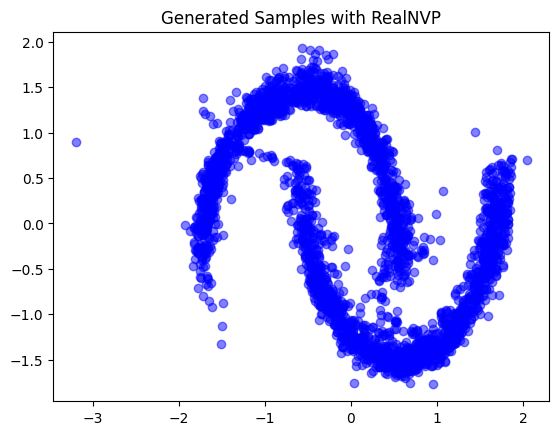

In [8]:
dataset = MoonsDataset()
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RealNVP(INPUT_DIM, COUPLING_DIM, COUPLING_LAYERS).to(DEVICE)

train(model, loader, EPOCHS, LR)

# Sampling
samples = model.sample(3000).cpu().detach().numpy()

plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Generated Samples with RealNVP')
plt.show()

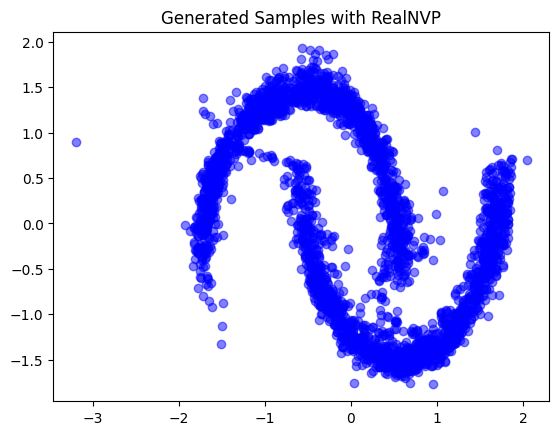

In [9]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Generated Samples with RealNVP')
plt.show()